In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/")

from numcosmo_py import Ncm, Nc, GObject

from richness_mass_calib import create_richness_mass_calib
import numpy as np
import math
import sys
import os.path

from astropy.io import fits
from astropy.table import Table
from scipy import stats

import matplotlib.pyplot as plt


In [2]:
#Settings
Ncm.cfg_init()

%matplotlib inline
sys.path.insert(0, "/global/homes/c/cinlima/gcr-catalogs")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy")


# DC2 data
DC2_halos_m200c = fits.open(
    "/global/cfs/projectdirs/lsst/groups/CL/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits")

dt_halos = Table(DC2_halos_m200c[1].data)

lnM = np.log(dt_halos["m200c"])  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)



def compute_res(rich_model):

    lnR_mean = np.array(
        [rich_model.get_mean_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )
    lnR_std = np.array(
        [rich_model.get_std_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )
    
    lnr_cut = np.array(
        [rich_model.get_cut(lnM[i], z[i]) for i in range(len(dt_halos))])

    abs_err = (lnR - lnR_mean) / lnR_std
    # Data cut
    sigma_cut = 5.0

    sigma_cut_array = np.abs(abs_err) < sigma_cut
    print(f"Cutting {sigma_cut}-sigma, {np.sum(np.logical_not(sigma_cut_array))}")

    lnR_mean = lnR_mean[sigma_cut_array]
    z_sigma_cut = z[sigma_cut_array]
    lnM_sigma_cut = lnM[sigma_cut_array]
    abs_err = abs_err[sigma_cut_array]
    lnR_ext = lnR[sigma_cut_array]
    lnr_cut = lnr_cut[sigma_cut_array] 
    
    return abs_err, lnR_mean, z_sigma_cut, lnM_sigma_cut, lnr_cut, lnR_ext 


In [32]:
# redshift bins
z_0 = 0.0
z_1 = 0.1
halos_bin_z =[]

for i in range(31):
    cut_z = np.logical_and (dt_halos['redshift_true'] > z_0, dt_halos['redshift_true'] < z_1)
    halos_bin_z.append(dt_halos[cut_z])
    z_0 = z_0 + 0.1
    z_1 = z_1 + 0.1

# mass bins
label = []
halos_bin_mz =[]
for i in range(30):
    lnM_0 = min(lnM)
    lnM_1 = min(lnM) + 0.5

    for j in range(9):
        cut = np.logical_and (np.log(halos_bin_z[i]["m200c"]) > lnM_0, np.log(halos_bin_z[i]["m200c"]) < lnM_1)
        halos_bin_mz.append(halos_bin_z[i][cut])
        label.append(f"{min(halos_bin_z[i]['redshift_true']):.3f} < z < {max(halos_bin_z[i]['redshift_true']):.3f}\n{lnM_0:.3f} < lnM < {lnM_1:.3f}")
        lnM_0 = lnM_0 + 0.5
        lnM_1 = lnM_1 + 0.5

In [33]:
fit_results_ascaso = []
fit_results_ext = []

mean_ext_list=[]

for i in range(len(halos_bin_mz)):
    
    if len(halos_bin_mz[i]) == 0:
        fit_results_ascaso.append(([], [], [], [], [] ,[]))
        fit_results_ext.append(([], [], [], [], [] ,[]))

    
    else:
        rmdata = create_richness_mass_calib(halos_bin_mz[i])

        use_ascaso = False

        ascaso = Nc.ClusterMassAscaso()

        ascaso.param_set_by_name("mup0", 4.45393539397061)
        ascaso.param_set_by_name("cut", 1e15)
        ascaso.param_set_by_name("mup1", 0.0)
        ascaso.param_set_by_name("mup2", 0.0)
        ascaso.param_set_by_name("sigmap0", 0.227197277810533)
        ascaso.param_set_by_name("sigmap1", 0.0)
        ascaso.param_set_by_name("sigmap2", 0.0)


        ascaso.param_set_ftype(0, Ncm.ParamType.FREE)
        ascaso.param_set_ftype(1, Ncm.ParamType.FIXED)
        ascaso.param_set_ftype(2, Ncm.ParamType.FIXED)
        ascaso.param_set_ftype(3, Ncm.ParamType.FREE)
        ascaso.param_set_ftype(4, Ncm.ParamType.FIXED)
        ascaso.param_set_ftype(5, Ncm.ParamType.FIXED)
        ascaso.param_set_ftype(6, Ncm.ParamType.FIXED)

        lnrich_ext = Nc.ClusterMassLnrichExt()
        lnrich_ext.param_set_by_name("mu", 4.60456407051582)
        lnrich_ext.param_set_by_name("muM1", 0.0)
        lnrich_ext.param_set_by_name("muZ1", 0.0)
        lnrich_ext.param_set_by_name("muM2", 0.0)
        lnrich_ext.param_set_by_name("muZ2", 0.0)
        lnrich_ext.param_set_by_name("muMZ", 0.0)
        
        lnrich_ext.param_set_by_name("sigma0", 0.288099083637692)
        lnrich_ext.param_set_by_name("sigmaM1", 0.0)
        lnrich_ext.param_set_by_name("sigmaZ1", 0.0)
        lnrich_ext.param_set_by_name("sigmaM2", 0.0)
        lnrich_ext.param_set_by_name("sigmaZ2", 0.0)
        lnrich_ext.param_set_by_name("sigmaMZ", 0.0)


        lnrich_ext.param_set_by_name("cut", 1e15)
        lnrich_ext.param_set_by_name("cutM1", 0)
        lnrich_ext.param_set_by_name("cutZ1", 0)


        lnrich_ext.param_set_ftype(0, Ncm.ParamType.FREE)
        lnrich_ext.param_set_ftype(1, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(2, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(3, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(4, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(5, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(6, Ncm.ParamType.FIXED)

        lnrich_ext.param_set_ftype(7, Ncm.ParamType.FREE)
        lnrich_ext.param_set_ftype(8, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(9, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(10, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(11, Ncm.ParamType.FIXED)

        lnrich_ext.param_set_ftype(12, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(13, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(14, Ncm.ParamType.FIXED)

        mset_ascaso = Ncm.MSet()
        mset_ascaso.set(ascaso)

        mset_ext = Ncm.MSet()
        mset_ext.set(lnrich_ext)

        dset = Ncm.Dataset.new()
        dset.append_data(rmdata)

        lh = Ncm.Likelihood.new(dset)

        fit_ascaso = Ncm.Fit.new( Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_ascaso, Ncm.FitGradType.NUMDIFF_CENTRAL )
        fit_ext = Ncm.Fit.new( Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_ext, Ncm.FitGradType.NUMDIFF_CENTRAL )

        fit_ascaso.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
        fit_ext.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
        
        res_ascaso, lnR_mean_ascaso, z_sigma_cut_ascaso, lnM_sigma_cut_ascaso, lnr_cut_ascaso, lnR_ascaso  = compute_res(ascaso)

        res_ext, lnR_mean_ext, z_sigma_cut_ext, lnM_sigma_cut_ext, lnr_cut_ext, lnR_ext  = compute_res(lnrich_ext)

        fit_results_ascaso.append((res_ascaso, lnR_mean_ascaso, z_sigma_cut_ascaso, lnM_sigma_cut_ascaso, lnr_cut_ascaso, lnR_ascaso))
        fit_results_ext.append((res_ext, lnR_mean_ext, z_sigma_cut_ext, lnM_sigma_cut_ext, lnr_cut_ext, lnR_ext))
        mean_ext_list.append(lnR_mean_ext)


#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#.................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0006570
#  iteration            [000081]
#  function evaluations [000083]
#  gradient evaluations [000000]
#  degrees of freedom   [000167]
#  m2lnL     =     134.276741619888 (     134.27674 )
#  Fit parameters:
#     1.57814408555312     0.451187951631736   
#----------------------------------------------------------------------------------
# Restarting:              yes
#  - absolute improvement: 27341.940837573       
#  - relative improvement: 0.995112983028582     
#  - m2lnL_0  :            27476.2175791929      
#  - m2lnL_1  :            134.276741619888      
#------------------------------------------------------------------

Text(0, 0.5, 'mean_err²')

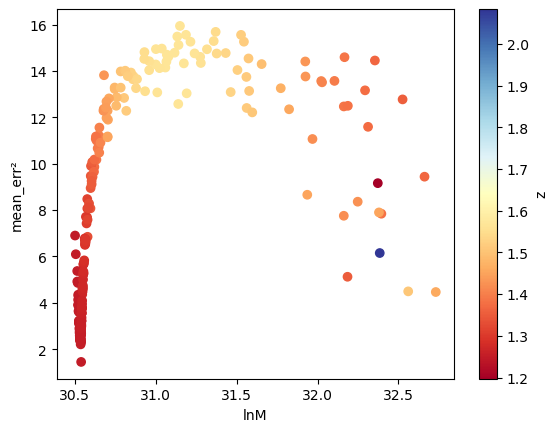

In [34]:
mean_tot_ascaso = [np.mean(err ** 2) for err, lnR_mean, z_sigma_cut, lnM_sigma_cut, cut, lnR in fit_results_ascaso if len(err)>0]

mean_z_ascaso = [np.mean(z_sigma_cut) for err, lnR_mean, z_sigma_cut, lnM_sigma_cut, cut, lnR  in fit_results_ascaso if len(z_sigma_cut) > 0]

mean_lnM_ascaso = [np.mean(lnM_sigma_cut) for err, lnR_mean, z_sigma_cut, lnM_sigma_cut, cut, lnR in fit_results_ascaso if len(lnM_sigma_cut) > 0]


#plt.scatter(mean_lnM_ascaso, mean_tot_ascaso)

plt.scatter(mean_lnM_ascaso, mean_tot_ascaso , c=mean_z_ascaso, cmap='RdYlBu')
plt.colorbar(label='z')

plt.xlabel('lnM')
plt.ylabel('mean_err²')


Text(0, 0.5, 'mean_err²')

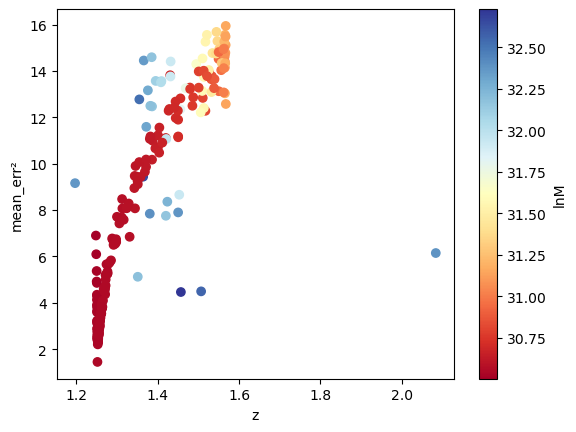

In [35]:
plt.scatter(mean_z_ascaso, mean_tot_ascaso , c=mean_lnM_ascaso, cmap='RdYlBu')
plt.colorbar(label='lnM')

plt.xlabel('z')
plt.ylabel('mean_err²')
